In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import math
from ultralytics import YOLO
import itertools

# import tensorflow as tf
from tensorflow.keras.models import load_model

# Load image

In [2]:
def resize(frame, width = 640, height = 640):
    return cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)

def preprocess_image(frame):
    return resize(frame)

def load_image(path):
    return cv.imread(path)

# Feature Extraction

In [3]:
def MaskStrength(mask, img):
    """
    Calculates Pixel Strength for mask
    1. Apply mask on the original color image
    2. Calculate average of non zero pixels
    """
    mask_3d = np.expand_dims(mask, axis=-1)
    masked_array = (img * mask_3d).flatten()
    return masked_array[masked_array>0].mean().round(2)

def MaskCentroid(mask):
    """
    Calculates Centroid for mask
    1. Extract indices of non zero pixels in a mask
    2. Calculate average of x and y coordinates
    3. Flip the array, since here x and y corresponds to row and column
    """
    mask_indices = np.where(mask)
    mask_centroid = np.round(np.mean(mask_indices, axis=1))
    flip_centroid = list(np.flip(mask_centroid))
    return flip_centroid

In [4]:
def extract_features_inferencing(results, feature_list):
# Check if atleast one mask exist
    frame = 0
    result = results[0]
    features = {key: [] for key in feature_list}
    d = {key: [] for key in ['n_masks', 'width', 'height', 'bbox_centroid', 'box_area', 'mask_area', 'mask_centroid', 'mask_strength']}
    if result.masks is not None:

        # Calculate number of masks in the segmented image
        features['n_masks'] = len(result.masks)    

        # Bounding Box Parameters
        bboxes = result.boxes

        bbox_data = np.array(bboxes.data)
        width = []
        height = []
        x_centroid = []
        y_centroid = []
        box_area = []
        for box in bbox_data:
            # Extract Bounding box dimension [Width, Height] for each box
            w = np.round(abs(box[0] - box[2]))
            h = np.round(abs(box[1] - box[3]))
            d['width'].append(w)
            d['height'].append(h)            

            # Extract Bounding box Centroid for each box
            xcoord = np.round(np.mean([box[0], box[2]]))
            ycoord = np.round(np.mean([box[1], box[3]]))
            d['bbox_centroid'].append([xcoord, ycoord])

            # Calculate Bounding box Area for each box
            d['box_area'].append(w*h)
        
        features['bbox_width'] = np.mean(d['width'])
        features['bbox_height'] = np.mean(d['height'])
        features['bbox_area'] = np.mean(d['box_area'])
        features['bbox_centroid_dist'] = calc_pair_distance(d['bbox_centroid'])
        
        # Mask Parameters
        masks = np.array(result.masks.data, dtype='uint8')
        mask_area = []
        
        for mask in masks:
            # Mask Area: Count number of non zero pixels in mask
            d['mask_area'].append(np.count_nonzero(mask))

            # Mask Centroid: Calculate mean of non zero pixel x and y coordinates
            d['mask_centroid'].append(MaskCentroid(mask))

            ## Mask Strength: 
            # Apply mask on the original image
            # Measure average pixel strength excluding non zero pixels
            d['mask_strength'].append(MaskStrength(mask, result.orig_img))        
        
        features['mask_area'] = np.mean(d['mask_area'])
        features['mask_strength'] = np.mean(d['mask_strength'])
        features['mask_centroid_dist'] = calc_pair_distance(d['mask_centroid'])
        
        return [features[key] for key in features.keys()]
    else:        
        return [0 for key in features.keys()]

In [5]:
def calc_dim(val, ind):
    val = np.array(val)
    if val.ndim == 1 and len(val) > 1: #Single Box
        return val[ind]
    elif val.ndim > 1: # More than 1 Box
        if len(val[:,0]) == 0:
            return -1
        return np.mean(val[:,0])
    else: # 0 Box
        return 0   
    
def calc_pair_distance(val):
    pair_distances = [np.linalg.norm(np.array(p1) - np.array(p2)) for p1, p2 in itertools.combinations(val, 2)]
    if len(pair_distances) != 0:    
        return np.round(sum(pair_distances) / len(pair_distances),2)
    else:
        return 0

# Visibility Estimation

In [6]:
class visibility_estimation():
    def __init__(self):
        self.gaussian_kernel = 3
        self.multiplier = 5
        self.ref_edges = -1
        
    def reference_visibility(self, ref_image_path):
        reference_image = load_image(ref_image_path)
        ref_preprocessed = preprocess_image(reference_image)
        self.ref_edges = self.count_edges(ref_preprocessed)
                
    def edge_detection(self, img):    
        gradx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
        grady = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
        return gradx, grady

    def preprocess(self, img):
        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_blur = cv.GaussianBlur(img, (self.gaussian_kernel, self.gaussian_kernel), 0)
        gradx, grady = self.edge_detection(img_blur)
        grad_mag = cv.magnitude(gradx, grady)
        grad_mag_norm = cv.normalize(grad_mag, None, 0, 255, cv.NORM_MINMAX)
        return grad_mag_norm

    def count_edges(self, target_img):
        preprocessed_img = self.preprocess(target_img)
        _, thresh = cv.threshold(preprocessed_img, self.multiplier * np.median(preprocessed_img), 255, cv.THRESH_BINARY)             
        total_edges = np.count_nonzero(thresh)
        return total_edges

    def edge_strength_ratio(self, preprocessed_img):
        if self.ref_edges > 0:
            target_edge = self.count_edges(preprocessed_img)
            print(target_edge, self.ref_edges)
            return np.round((target_edge / self.ref_edges),2)
        else:
            print("Estimate Reference Visibility")
            return -1

# Hydrogen Spark Detection

In [7]:
class spark_detection():
    def __init__(self):
        self.yolo_model_path = r"Models\yolo_model.pt"
        self.lstm_model_path = r"Models\lstm_model.h5"
        self.feature_list = ['n_masks', 'mask_area', 'bbox_area','mask_strength','bbox_width', 'bbox_height', 'mask_centroid_dist', 'bbox_centroid_dist']
        self.lstm_input = np.zeros((10, len(self.feature_list)))
        
        
    def load_models(self):
        try:
            print
            self.yolo_model = YOLO(self.yolo_model_path)                       
        except:
            print("Error Loading YOLO Model")
            
        try:
            self.lstm_model = load_model(self.lstm_model_path)                      
        except:
            print("Error Loading LSTM Model")

    def update_window(self, new):
        self.lstm_input[:-1] = self.lstm_input[1:]
        self.lstm_input[-1] = new

    def inference_image(self, img_path):
        raw_image = load_image(img_path)
    
        # Preprocess Image
        processed_image = preprocess_image(raw_image)

        # YOLO Inferencing
        results = self.yolo_model(processed_image, conf=0.2, iou=0.5, save=True, show_labels=False, retina_masks=True)

        # Feature Extraction
        extracted_features = extract_features_inferencing(results, self.feature_list)    

        # Prepare Data
        self.update_window(extracted_features)

        # LSTM Inferencing
        final_result = self.lstm_model.predict(self.lstm_input[np.newaxis, :])[0][0]
        
        return results, final_result
        

# Test

In [8]:
ref_image = r"F:\Work\SOCAAutomation\Dataset\Images\Reference_Images\04_07_2024\1.jpg"
test_folder = r"F:\Work\SOCAAutomation\Dataset\Images\TestImages\5"
res = []
det_obj = spark_detection()
det_obj.load_models()


In [9]:
vis_est = visibility_estimation()
vis_est.reference_visibility(ref_image)

In [50]:
for ind, file in enumerate(os.listdir(test_folder)):
    if not file == "9.jpg":
        continue
    # Load Image
    print(f"Loading Image: {file}")
    yolo_res, lstm_res = det_obj.inference_image(test_folder + "/" + file)   

    print("Image Inferenced...")
    print("")
    break

Loading Image: 9.jpg

0: 640x640 1 Fire, 4536.5ms
Speed: 8.0ms preprocess, 4536.5ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict44
1/1 [==============================] - 1s 515ms/step
Image Inferenced...



In [16]:
# Video Generation
frame = resize(cv.imread(test_folder + "/" + file))

mask = yolo_res[0].masks.data[0].cpu().numpy()  # First detected mask
mask = cv.resize(mask, (640, 640))
mask_color = np.zeros_like(frame)
mask_color[:, :, 2] = (mask * 255).astype(np.uint8)  # Red channel

overlay = cv.addWeighted(frame, 0.7, mask_color, 0.3, 0)
import matplotlib.pyplot as plt
cv.imwrite('out.jpg', overlay)


True

In [26]:
alpha = 0.3

cv.imwrite('out.jpg', result_img)

True

In [26]:
output_video = 'fire_demo_All.mp4'
w = 640
h = 640
fourcc = cv.VideoWriter_fourcc(*'mp4v')
video = cv.VideoWriter(output_video, fourcc, 15, (w*2, h))
font = cv.FONT_HERSHEY_SIMPLEX
src_folder = r"F:\Work\SOCAAutomation\Dataset\Images\TestImages"
logs_lstm = []
def_hold_time = 10
for folder in os.listdir(src_folder):
    test_folder = src_folder + "/" + folder
    print(f"Folder {folder} is started...")
    images = sorted(
        [f for f in os.listdir(test_folder) if f.endswith(".jpg")],
        key=lambda x: int(os.path.splitext(x)[0])
    )
    spark_frame = 0
    hold_time = 0
    for ind, img_name in enumerate(images):
        print(f"{img_name} is being inferenced...")
        raw_path = os.path.join(test_folder, img_name)
        raw_img = resize(cv.imread(raw_path))

        # YOLO segmentation output
        result_img = raw_img.copy()    
        yolo_res, lstm_res = det_obj.inference_image(test_folder + "/" + img_name)  
        logs_lstm.append(lstm_res)
        if yolo_res[0].masks is not None:
            masks = yolo_res[0].masks.data.cpu().numpy()  # (num_masks, h, w)

            # Combine all masks (if multiple fire regions)
            combined_mask = np.any(masks, axis=0).astype(np.uint8)

            # Resize to match frame size (YOLO may resize internally)
            combined_mask = cv.resize(combined_mask, (w, h))
            fire_color = (255, 0, 0)  # pure red
            alpha = 0.5
            result_img = np.where(
                combined_mask[..., None] == 1,
                cv.addWeighted(result_img, 1 - alpha, np.full_like(result_img, fire_color), alpha, 0),
                raw_img
            )
            
        # Add Visibility
        visibility = vis_est.edge_strength_ratio(preprocess_image(raw_img))
        cv.putText(result_img, f"Visibility: {visibility * 100: .0f}%", (350, 50), font, 1.2, (0,255,255), 3)

        if lstm_res > 0.5 or hold_time > 0:
            if lstm_res > 0.5:
                hold_time = def_hold_time
            else:
                hold_time -= 1
                if hold_time < 0:
                    hold_time = 0                
            if spark_frame < 5:
                if int(folder) > 2:
                    cv.putText(result_img, "!HYDROGEN SPARK DETECTED!", (50, 500),
                               cv.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 4, cv.LINE_AA)
                spark_frame += 1
            else:
                if int(folder) > 2:
                    cv.putText(result_img, "!HYDROGEN SPARK DETECTED!", (50, 500),
                               cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 4, cv.LINE_AA)
                spark_frame = 0


        # --- Combine images horizontally ---
        combined = np.hstack((raw_img, result_img))

        # Write frame to video
        video.write(combined)
        

video.release()
print(f"✅ Video saved as {output_video}")

Folder 1 is started...
1.jpg is being inferenced...

0: 640x640 (no detections), 4346.8ms
Speed: 8.1ms preprocess, 4346.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 510ms/step
85517 139026
47.jpg is being inferenced...

0: 640x640 (no detections), 3905.9ms
Speed: 7.4ms preprocess, 3905.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
84307 139026
48.jpg is being inferenced...

0: 640x640 (no detections), 4114.1ms
Speed: 9.0ms preprocess, 4114.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
84269 139026
49.jpg is being inferenced...

0: 640x640 (no detections), 3976.3ms
Speed: 13.7ms preprocess, 3976.3ms inference, 10.0ms postprocess per image at shape (1, 3, 

Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
80194 139026
109.jpg is being inferenced...

0: 640x640 1 Fire, 3900.2ms
Speed: 0.0ms preprocess, 3900.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 697ms/step
81486 139026
110.jpg is being inferenced...

0: 640x640 1 Fire, 3912.9ms
Speed: 0.0ms preprocess, 3912.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
81120 139026
111.jpg is being inferenced...

0: 640x640 1 Fire, 3910.4ms
Speed: 19.9ms preprocess, 3910.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 497ms/step
81014 139026
112.jpg is being inferenced...

0: 640x640 1 Fire, 3915.8ms
Speed: 10.0ms preprocess, 3915.8ms i

Results saved to runs\segment\predict45
1/1 [==============================] - 0s 493ms/step
78561 139026
4.jpg is being inferenced...

0: 640x640 (no detections), 3936.6ms
Speed: 0.0ms preprocess, 3936.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 590ms/step
82593 139026
5.jpg is being inferenced...

0: 640x640 (no detections), 3993.2ms
Speed: 10.0ms preprocess, 3993.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
75243 139026
6.jpg is being inferenced...

0: 640x640 (no detections), 4067.0ms
Speed: 10.0ms preprocess, 4067.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 500ms/step
76838 139026
91.jpg is being inferenced...

0: 640x640 (no detections), 4106.4ms
Speed: 1

Speed: 10.0ms preprocess, 3876.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
79975 139026
118.jpg is being inferenced...

0: 640x640 1 Fire, 4260.3ms
Speed: 10.0ms preprocess, 4260.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
79965 139026
119.jpg is being inferenced...

0: 640x640 1 Fire, 3909.2ms
Speed: 10.0ms preprocess, 3909.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
77234 139026
120.jpg is being inferenced...

0: 640x640 1 Fire, 3907.3ms
Speed: 10.0ms preprocess, 3907.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
79261 

78513 139026
150.jpg is being inferenced...

0: 640x640 1 Fire, 4714.1ms
Speed: 15.2ms preprocess, 4714.1ms inference, 30.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 630ms/step
78490 139026
151.jpg is being inferenced...

0: 640x640 1 Fire, 4723.8ms
Speed: 13.0ms preprocess, 4723.8ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 577ms/step
76365 139026
152.jpg is being inferenced...

0: 640x640 1 Fire, 4396.8ms
Speed: 6.9ms preprocess, 4396.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 547ms/step
76349 139026
153.jpg is being inferenced...

0: 640x640 1 Fire, 3911.6ms
Speed: 12.4ms preprocess, 3911.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segme

1/1 [==============================] - 1s 509ms/step
73853 139026
211.jpg is being inferenced...

0: 640x640 2 Fires, 4232.0ms
Speed: 6.0ms preprocess, 4232.0ms inference, 14.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 497ms/step
72552 139026
212.jpg is being inferenced...

0: 640x640 2 Fires, 4411.6ms
Speed: 6.0ms preprocess, 4411.6ms inference, 12.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 526ms/step
72520 139026
213.jpg is being inferenced...

0: 640x640 2 Fires, 3974.6ms
Speed: 16.7ms preprocess, 3974.6ms inference, 12.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 524ms/step
72827 139026
214.jpg is being inferenced...

0: 640x640 1 Fire, 5590.3ms
Speed: 7.3ms preprocess, 5590.3ms inference, 10.1ms postprocess per imag

Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
70491 139026
374.jpg is being inferenced...

0: 640x640 1 Fire, 3960.2ms
Speed: 10.0ms preprocess, 3960.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 500ms/step
70228 139026
375.jpg is being inferenced...

0: 640x640 1 Fire, 3860.1ms
Speed: 10.0ms preprocess, 3860.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 540ms/step
74899 139026
376.jpg is being inferenced...

0: 640x640 1 Fire, 4080.2ms
Speed: 10.0ms preprocess, 4080.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 601ms/step
69255 139026
377.jpg is being inferenced...

0: 640x640 1 Fire, 3856.1ms
Speed: 7.3ms preprocess, 3856.1ms

0: 640x640 3 Fires, 3900.6ms
Speed: 6.3ms preprocess, 3900.6ms inference, 40.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 500ms/step
50134 139026
69.jpg is being inferenced...

0: 640x640 1 Fire, 4167.0ms
Speed: 9.9ms preprocess, 4167.0ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 506ms/step
52684 139026
70.jpg is being inferenced...

0: 640x640 1 Fire, 4023.0ms
Speed: 7.2ms preprocess, 4023.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 510ms/step
48292 139026
71.jpg is being inferenced...

0: 640x640 1 Fire, 3896.5ms
Speed: 10.2ms preprocess, 3896.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================]

1/1 [==============================] - 0s 484ms/step
47368 139026
114.jpg is being inferenced...

0: 640x640 2 Fires, 3853.3ms
Speed: 13.3ms preprocess, 3853.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
47048 139026
115.jpg is being inferenced...

0: 640x640 2 Fires, 4173.4ms
Speed: 16.6ms preprocess, 4173.4ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 482ms/step
47644 139026
116.jpg is being inferenced...

0: 640x640 2 Fires, 4578.6ms
Speed: 14.8ms preprocess, 4578.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 510ms/step
47705 139026
117.jpg is being inferenced...

0: 640x640 2 Fires, 3823.9ms
Speed: 13.1ms preprocess, 3823.9ms inference, 10.0ms postprocess per 

Results saved to runs\segment\predict45
1/1 [==============================] - 0s 475ms/step
39708 139026
190.jpg is being inferenced...

0: 640x640 1 Fire, 3944.3ms
Speed: 14.8ms preprocess, 3944.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 498ms/step
41853 139026
191.jpg is being inferenced...

0: 640x640 1 Fire, 3874.6ms
Speed: 12.2ms preprocess, 3874.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
41828 139026
222.jpg is being inferenced...

0: 640x640 2 Fires, 3845.6ms
Speed: 7.0ms preprocess, 3845.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 477ms/step
39429 139026
223.jpg is being inferenced...

0: 640x640 2 Fires, 4164.8ms
Speed: 15.4ms preprocess, 4164.8

Results saved to runs\segment\predict45
1/1 [==============================] - 0s 469ms/step
40829 139026
404.jpg is being inferenced...

0: 640x640 1 Fire, 3898.3ms
Speed: 16.5ms preprocess, 3898.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 481ms/step
46055 139026
405.jpg is being inferenced...

0: 640x640 1 Fire, 4034.9ms
Speed: 12.1ms preprocess, 4034.9ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 488ms/step
45241 139026
406.jpg is being inferenced...

0: 640x640 1 Fire, 3838.6ms
Speed: 14.8ms preprocess, 3838.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
45201 139026
407.jpg is being inferenced...

0: 640x640 1 Fire, 3912.8ms
Speed: 7.3ms preprocess, 3912.8ms

Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
36057 139026
59.jpg is being inferenced...

0: 640x640 (no detections), 3820.1ms
Speed: 9.9ms preprocess, 3820.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 520ms/step
36094 139026
60.jpg is being inferenced...

0: 640x640 (no detections), 3990.1ms
Speed: 10.0ms preprocess, 3990.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 500ms/step
36679 139026
61.jpg is being inferenced...

0: 640x640 (no detections), 3920.1ms
Speed: 0.0ms preprocess, 3920.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
34182 139026
62.jpg is being inferenced...

0: 640x640 (no detections), 3810.1ms
Speed:

Speed: 10.0ms preprocess, 3920.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
29851 139026
4.jpg is being inferenced...

0: 640x640 (no detections), 3890.1ms
Speed: 10.0ms preprocess, 3890.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
29851 139026
5.jpg is being inferenced...

0: 640x640 (no detections), 3800.1ms
Speed: 10.0ms preprocess, 3800.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
28283 139026
6.jpg is being inferenced...

0: 640x640 (no detections), 3890.1ms
Speed: 10.0ms preprocess, 3890.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 

1/1 [==============================] - 1s 680ms/step
27524 139026
52.jpg is being inferenced...

0: 640x640 (no detections), 4000.1ms
Speed: 10.0ms preprocess, 4000.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 500ms/step
27524 139026
53.jpg is being inferenced...

0: 640x640 (no detections), 3910.1ms
Speed: 0.0ms preprocess, 3910.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
23568 139026
54.jpg is being inferenced...

0: 640x640 1 Fire, 3950.2ms
Speed: 0.0ms preprocess, 3950.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
22993 139026
55.jpg is being inferenced...

0: 640x640 1 Fire, 3880.1ms
Speed: 0.0ms preprocess, 3880.1ms inference, 0.0ms postprocess 

Results saved to runs\segment\predict45
1/1 [==============================] - 1s 500ms/step
27734 139026
130.jpg is being inferenced...

0: 640x640 (no detections), 3850.1ms
Speed: 10.0ms preprocess, 3850.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 480ms/step
27731 139026
131.jpg is being inferenced...

0: 640x640 1 Fire, 3890.1ms
Speed: 10.0ms preprocess, 3890.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 1s 540ms/step
27872 139026
132.jpg is being inferenced...

0: 640x640 1 Fire, 4020.2ms
Speed: 10.0ms preprocess, 4020.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict45
1/1 [==============================] - 0s 490ms/step
27872 139026
133.jpg is being inferenced...

0: 640x640 1 Fire, 4050.2ms
Speed: 10.0ms preprocess,

True


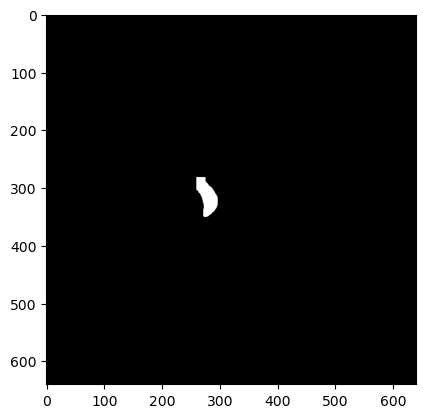

In [34]:
test_img_resized = preprocess_image(cv.imread(test_folder + "/" + file))
if yolo_res[0].masks is not None:
    masks = np.array(yolo_res[0].masks.data)
    combined_mask = np.any(masks, axis=0).astype(np.uint8)
    combined_mask_3ch = cv.merge([combined_mask * 255]*3)
    print("True")
else:
    combined_mask_3ch = np.zeros((640, 640, 3), dtype=np.uint8)
masked_img = cv.bitwise_and(test_img_resized, test_img_resized, mask=combined_mask)
plt.imshow(combined_mask_3ch)

True